# Прикладная задача: конвейер распознавания лиц
**Гистограмма направленных градиентов (histogram of oriented gradients, HOG)** - методика выделения признаков, которая преобразует пикселы изображения в векторное представление, чувствительное к несущим информацию признакам изображения, без учета таких факторов, как освещенность.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Признаки в методе HOG
Гистограмма направленных градиентов - простая процедура выделения признаков, разработанная для идентификации пешеходов на изображениях. Метод HOG включает следующие этапы:

1. Необязательная предварительная нормализация изображений. В результате получаются признаки, слабо зависящие от изменения освещенности.
2. Операция свертывания изображения с помощью двух фильтров, чувствительных к горизонтальным и вертикальным градиентам яркости. Это позволяет уловить информацию о границах, контурах и текстурах изображения.
3. Разбивка изображения на ячейки заранее определенного размера и вычисление гистограммы направлений градиентов в каждой из ячеек.
4. Нормализация гистограмм в каждой из ячеек путем сравнения с несколькими близлежащими ячейками. Это еще больше подавляет влияние освещенности на изображение.
5. Формирование одномерного вектора признаков из информации по каждой ячейке.

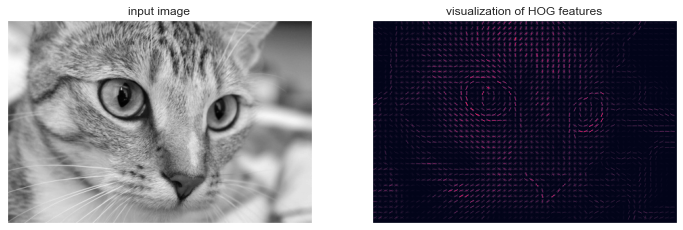

In [4]:
from skimage import data, color, feature
import skimage.data

image = color.rgb2gray(data.chelsea())
hog_vec, hog_vis = feature.hog(image, visualize=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis)
ax[1].set_title('visualization of HOG features');

## Метод HOG в действии: простой детектор лиц
На основе признаков HOG можно создать простой алгоритм обнаружения лиц с помощью любого из оценивателей библиотеки Scikit-Learn. Мы воспользуемся линейным методом опорных векторов. Алгоритм включает следующие шаги:

1. Получение миниатюры изображений, на которых представлены лица, для формирования "положительных" обучающих выборок.
2. Получение миниатюры изображений, на которые не представлены лица для формирования набора "отрицательных" обучающих выборок.
3. Выделение HOG-признаков из этих обучающих выборок.
4. Обучение линейного SVM-классификатора на этих выборках.
5. В случае "незнакомого" изображения перемещаем по изображению скользящее окно, применяя нашу модель для определения того, содержится ли в этом окне лицо или нет.
6. Если обнаруженные лица частично пересекаются, объединяем их в одно окно.

In [5]:
# 1 шаг:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

In [107]:
# 2 шаг:
from skimage import data, transform

imgs_to_use = ['immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']

images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

imgs_to_use_color = ['camera', 'text', 'coins', 'moon',
               'page', 'clock']

[images.append(getattr(data, name)()) for name in imgs_to_use_color]

[None, None, None, None, None, None]

In [112]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 62, 47)

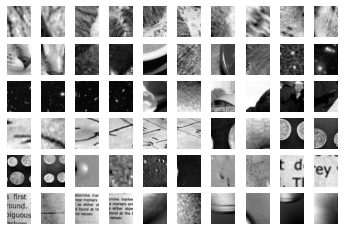

In [113]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')

In [114]:
# 3 шаг:
from itertools import chain
X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [115]:
X_train.shape

(43233, 1215)

In [117]:
# 4 шаг:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

cross_val_score(GaussianNB(), X_train, y_train)

array([0.97582977, 0.97363247, 0.94587718, 0.97177886, 0.97328244])

In [119]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

C:\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\s

0.9890823731993551

In [120]:
grid.best_params_

{'C': 1.0}

In [121]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC()

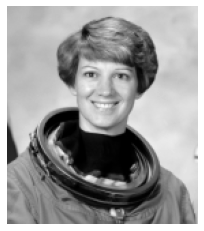

In [122]:
# 5 шаг:
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off');

In [123]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
            
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(1911, 1215)

In [124]:
# из 2000 фрагментов найдено 48 лиц
labels = model.predict(patches_hog)
labels.sum()

48.0

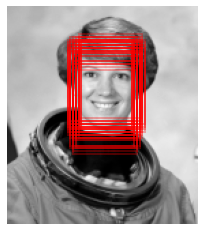

In [125]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))